# 📞 Identificación de Operadores Ineficaces — CallMeMaybe

## Descripción del Proyecto

El servicio de telefonía virtual **CallMeMaybe** necesita identificar a sus operadores menos eficaces para que la administración pueda tomar decisiones informadas sobre redistribución de tareas, capacitación o contratación de personal.

Se considera que un operador es **ineficaz** si presenta alguna de estas características:
- Alta proporción de **llamadas entrantes perdidas**
- **Tiempo de espera prolongado** para las llamadas entrantes
- **Bajo número de llamadas salientes** (cuando tiene asignadas tareas salientes)

---

## 🎯 Objetivos

- Realizar un análisis exploratorio de los datos para comprender patrones y tendencias en las métricas clave.
- Definir umbrales estadísticos para clasificar a los operadores como ineficaces.
- Validar hipótesis estadísticas para respaldar las conclusiones.
- Presentar recomendaciones accionables para mejorar la eficiencia del servicio.

---

## 🗂️ Fuentes de Datos

| Archivo | Descripción |
|---------|-------------|
| `telecom_clients_us.csv` | Información de los clientes: plan tarifario y fecha de inicio |
| `telecom_dataset_us.csv` | Registro detallado de llamadas realizadas y recibidas |

---

## 📋 Criterios de Clasificación de Ineficiencia

| Métrica | Criterio |
|---------|---------|
| Tasa de llamadas perdidas | Operadores en el **cuartil superior (Q3)** de la distribución |
| Tiempo promedio de espera | Operadores en el **cuartil superior (Q3)** de la distribución |
| Llamadas salientes | Operadores en el **cuartil inferior (Q1)** de la distribución |


## Desarrollo del Proyecto

### 1. Análisis Exploratorio de Datos

In [28]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pandas.plotting import table
import numpy as np

In [29]:
# Cargar tabla de clientes (telecom_clients_us.csv)
df_clients = pd.read_csv('telecom_clients_us.csv')
print("Información de df_clients:")
print(df_clients.info())
print()
print(df_clients.head())
print()
print(df_clients.isnull().sum())

Información de df_clients:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

user_id        0
tariff_plan    0
date_start     0
dtype: int64


**Estructura de `df_clients`:**
- 732 registros, 3 columnas: `user_id`, `tariff_plan`, `date_start`
- No tiene valores nulos

**Descripción de columnas:**
- `user_id`: Identificador del usuario. Clave para unir con la otra tabla.
- `tariff_plan`: Plan tarifario (A, B, C, etc.)
- `date_start`: Fecha de inicio del plan. Requiere conversión a `datetime`.


In [30]:
# Cargar tabla de llamadas (telecom_dataset_us.csv)
df_calls = pd.read_csv('telecom_dataset_us.csv')
print("Información de df_calls:")
print(df_calls.info())
print()
print(df_calls.sample(5))
print()
print(df_calls.isnull().sum())

Información de df_calls:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None

       user_id                       date direction internal  operator_id  \
52184   168361  2019-11-01 00:00:00+03:00       out    False     945310.0   
1053    166405  2019-09-25 00:00:00+03:00       out    False     882686.0   
5320    1

**Estructura de `df_calls`:**
- 53,902 registros, 9 columnas
- Columnas con valores nulos: 117 en `internal` y 8,172 en `operator_id`

**Descripción de columnas:**
- `user_id`: Identificador del usuario.
- `date`: Fecha de la llamada. Requiere conversión a `datetime`.
- `direction`: Dirección de la llamada (`in` o `out`).
- `internal`: Si la llamada fue interna. Tipo booleano. Tiene nulos.
- `operator_id`: ID del operador. Tiene bastantes valores faltantes (15% de los registros).
- `is_missed_call`: Si la llamada fue perdida.
- `calls_count`: Número de llamadas en ese registro.
- `call_duration`: Duración de la llamada en espera (segundos).
- `total_call_duration`: Duración total incluyendo conversación (segundos).

Ambas tablas comparten el campo `user_id`, lo que permite hacer una unión para enriquecer el análisis.


### 2. Procesamiento de Datos

#### Tratamiento de Valores Ausentes

- `df_clients`: no tiene valores ausentes.
- `df_calls`: tiene valores ausentes en `internal` (117) y `operator_id` (8,172).

**`internal`**: 117 nulos sobre 53,785 registros. Contiene valores `True` o `False`. Se reemplazarán con el valor más frecuente.


In [31]:
# Identificar el valor más frecuente de 'internal'
df_calls['internal'].value_counts(dropna=False)

internal
False    47621
True      6164
NaN        117
Name: count, dtype: int64

In [32]:
# Convertir 'internal' a booleano y reemplazar nulos con el valor más frecuente (False)
df_calls['internal'] = df_calls['internal'].astype(str).map({'True': True, 'False': False})
df_calls['internal'] = df_calls['internal'].astype('boolean')
df_calls['internal'] = df_calls['internal'].fillna(False)

In [33]:
# Verificar que no haya nulos en 'internal'
df_calls['internal'].value_counts(dropna=False)

internal
False    47738
True      6164
Name: count, dtype: Int64

**`operator_id`**: 8,172 nulos (15% de los registros). Esta columna es clave para el análisis ya que está directamente ligada al objetivo del estudio.

No se reemplaza con el valor más frecuente porque podría distorsionar la identificación del operador más ineficiente. En cambio, se asigna el valor `-1` como marcador distintivo para registros sin operador asignado. A lo largo del análisis se tomará una decisión final sobre estos registros.


In [34]:
# Identificar valores más frecuentes de 'operator_id'
df_calls['operator_id'].value_counts(dropna=False)

operator_id
NaN         8172
901884.0     348
901880.0     337
893804.0     325
885876.0     319
            ... 
954284.0       1
940772.0       1
964518.0       1
908180.0       1
960674.0       1
Name: count, Length: 1093, dtype: int64

Los valores nulos en `operator_id` son significativamente más altos que cualquier operador individual. El operador con más registros tiene 348, muy por debajo de los 8,172 nulos — confirma que reemplazarlos por el valor más frecuente habría sido incorrecto.

In [35]:
# Reemplazar valores nulos de 'operator_id' con -1
df_calls['operator_id'] = df_calls['operator_id'].fillna(-1)
print(f"Nulos restantes en operator_id: {df_calls['operator_id'].isnull().sum()}")

Nulos restantes en operator_id: 0


#### Corrección de Tipos de Datos

In [36]:
# Convertir columnas de fechas a datetime
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])
df_calls['date']         = pd.to_datetime(df_calls['date'])
print("Tipos de datos actualizados correctamente.")

Tipos de datos actualizados correctamente.


#### Verificación y Tratamiento de Duplicados

In [37]:
print(f"Duplicados en df_clients: {df_clients.duplicated().sum()}")
print(f"Duplicados en df_calls:   {df_calls.duplicated().sum()}")

Duplicados en df_clients: 0
Duplicados en df_calls:   4900


Un 9.1% de las filas en `df_calls` están duplicadas. Dado que la columna `date` incluye minutos y segundos, es muy poco probable que dos registros idénticos correspondan a eventos distintos. Se asume que son errores de registro y se eliminan.

In [38]:
# Eliminar duplicados en df_calls
df_calls.drop_duplicates(inplace=True)
print(f"Duplicados restantes: {df_calls.duplicated().sum()}")
print(f"Registros tras limpieza: {len(df_calls):,}")

Duplicados restantes: 0
Registros tras limpieza: 49,002


#### Verificación de Inconsistencias

In [39]:
# Estadísticas descriptivas de df_clients
df_clients.describe()

,user_id,date_start
count,732.000000,732
mean,167431.927596,2019-09-14 16:39:20.655737600
min,166373.000000,2019-08-01 00:00:00
25%,166900.750000,2019-08-23 00:00:00
50%,167432.000000,2019-09-16 00:00:00
75%,167973.000000,2019-10-08 00:00:00
max,168606.000000,2019-10-31 00:00:00
std,633.810383,NaN


Los `user_id` son numéricos y consecutivos, sin valores fuera de rango. Las fechas se encuentran entre agosto y octubre de 2019, coherentes con el período de observación. No se detectan inconsistencias.

In [40]:
# Estadísticas descriptivas de df_calls
df_calls.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,777067.674911,16.462777,866.282091,1156.558202
std,598.558965,329774.097100,63.604098,3775.503352,4451.473661
min,166377.000000,-1.000000,1.000000,0.000000,0.000000
25%,166782.000000,890416.000000,1.000000,0.000000,46.000000
50%,167158.000000,906406.000000,4.000000,37.000000,208.000000
75%,167819.000000,929884.000000,12.000000,570.000000,901.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


Observaciones relevantes:
- `operator_id` tiene valor mínimo = -1, que es el marcador asignado para datos faltantes.
- `calls_count` tiene media de 16.46 pero máximo de 4,817 — distribución muy sesgada. El 75% de los registros tiene ≤12 llamadas. Se analizarán estos valores extremos.
- `call_duration` y `total_call_duration` tienen máximos muy altos (>40 horas), posiblemente acumulación de llamadas. Se explorarán visualmente.


In [41]:
# Visualizar los valores más altos de 'calls_count'
df_calls[['user_id', 'date', 'calls_count']].sort_values(by='calls_count', ascending=False).head(10)

,user_id,date,calls_count
40733,167827,2019-11-11 00:00:00+03:00,4817
40671,167827,2019-10-31 00:00:00+03:00,2614
37070,167626,2019-10-07 00:00:00+03:00,2168
37102,167626,2019-10-08 00:00:00+03:00,1917
37553,167626,2019-10-15 00:00:00+03:00,1914
37308,167626,2019-10-11 00:00:00+03:00,1705
50837,168252,2019-11-25 00:00:00+03:00,1679
36913,167626,2019-10-04 00:00:00+03:00,1641
50888,168252,2019-11-26 00:00:00+03:00,1590
40690,167827,2019-11-05 00:00:00+03:00,1533


Los usuarios `167827` y `167626` aparecen múltiples veces con valores muy altos, lo que sugiere perfiles de uso atípicos o posibles errores de acumulación.

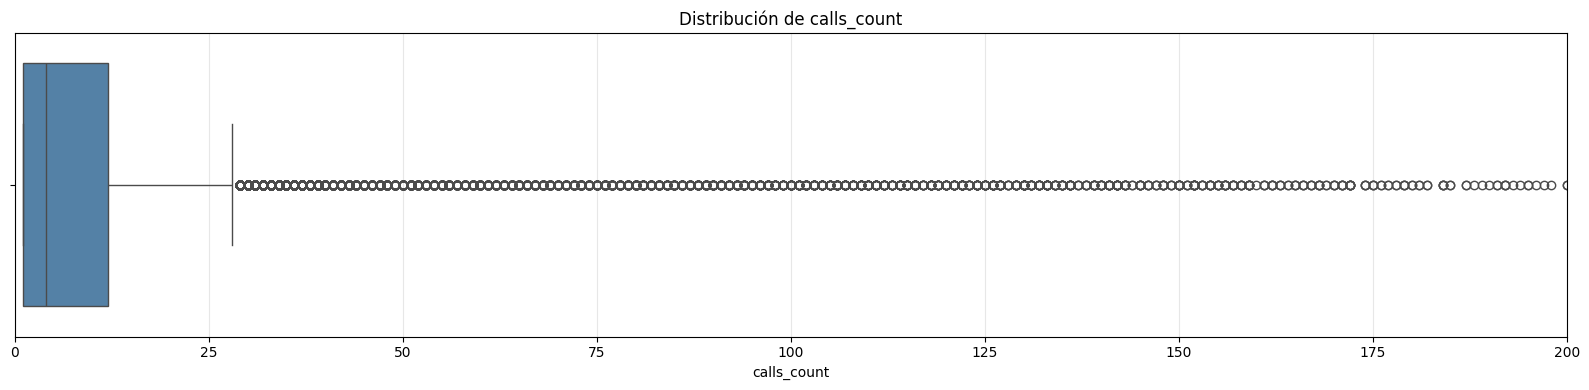

In [42]:
# Boxplot de calls_count para detectar outliers
plt.figure(figsize=(16, 4))
sns.boxplot(x=df_calls['calls_count'], color='steelblue')
plt.title('Distribución de calls_count')
plt.xlabel('calls_count')
plt.xlim(0, 200)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

La mayoría de los registros tienen entre 1 y 30 llamadas. A partir de ~30 ya se consideran outliers. La distribución es claramente sesgada hacia la derecha con una larga cola de valores extremos.

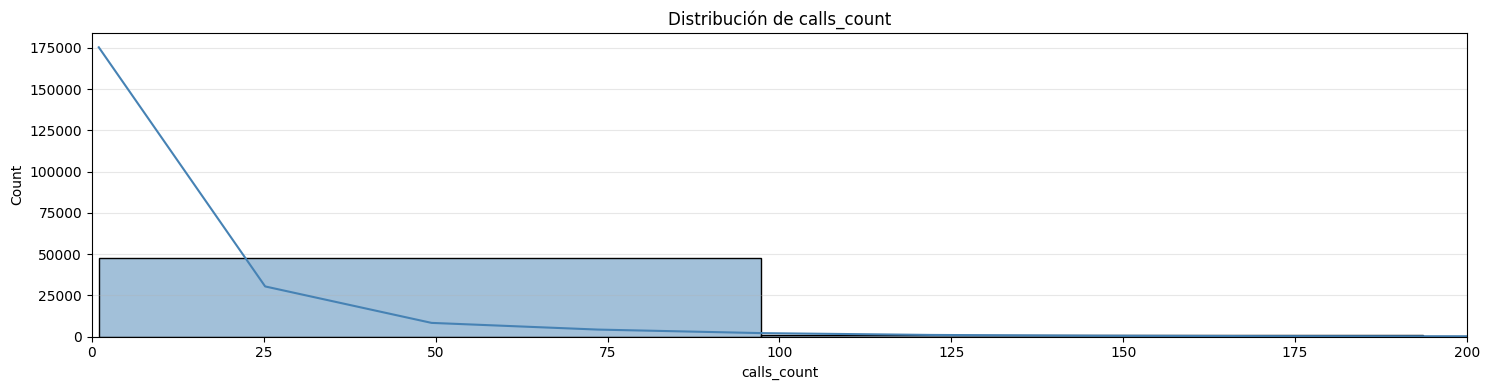

In [43]:
# Histograma de calls_count
plt.figure(figsize=(15, 4))
sns.histplot(df_calls['calls_count'], bins=50, kde=True, color='steelblue')
plt.title('Distribución de calls_count')
plt.xlabel('calls_count')
plt.xlim(0, 200)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

El histograma confirma la concentración de datos entre 0 y 25 llamadas, con frecuencia muy baja a partir de 100. Se conservan los outliers para mantener la integridad de los datos — podrían reflejar ineficiencias reales de operadores.

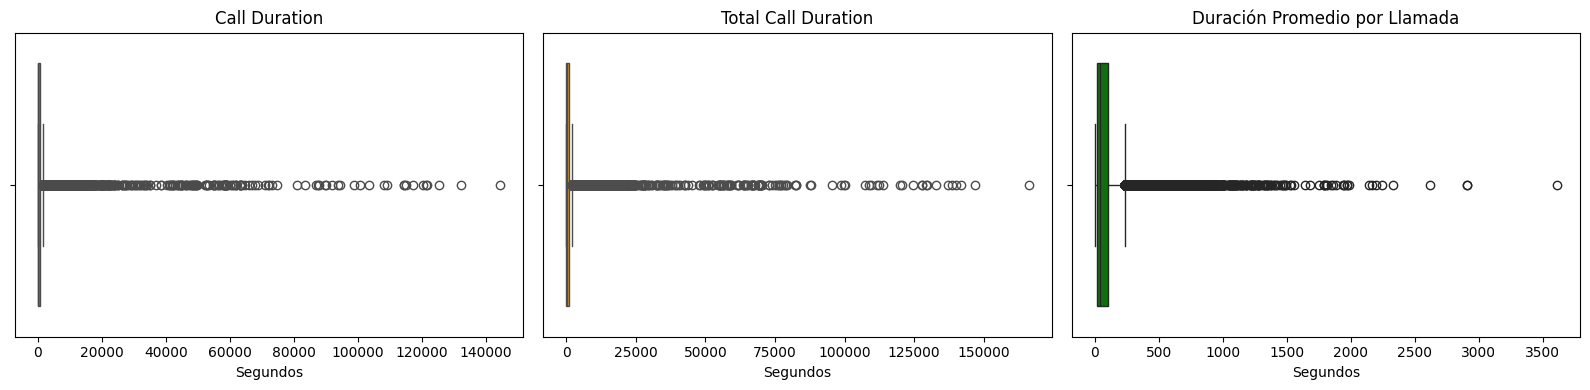

In [44]:
# Análisis de duración de llamadas
df_calls['avg_call_duration'] = df_calls['total_call_duration'] / df_calls['calls_count']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.boxplot(x=df_calls['call_duration'],       ax=axes[0], color='steelblue')
axes[0].set_title('Call Duration')
axes[0].set_xlabel('Segundos')

sns.boxplot(x=df_calls['total_call_duration'],  ax=axes[1], color='orange')
axes[1].set_title('Total Call Duration')
axes[1].set_xlabel('Segundos')

sns.boxplot(x=df_calls['avg_call_duration'],    ax=axes[2], color='green')
axes[2].set_title('Duración Promedio por Llamada')
axes[2].set_xlabel('Segundos')

plt.tight_layout()
plt.show()

Las tres métricas muestran distribuciones con valores extremos. Los máximos (>40 horas) probablemente corresponden a acumulaciones válidas de muchas llamadas en un día. Se conservan para no perder información que podría evidenciar ineficiencias reales.

#### Unificación de Datasets

In [45]:
# Unir ambas tablas por 'user_id'
df_general = pd.merge(df_calls, df_clients, on='user_id', how='left')
print("Información de df_general:")
df_general.info()

Información de df_general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              49002 non-null  int64                    
 1   date                 49002 non-null  datetime64[ns, UTC+03:00]
 2   direction            49002 non-null  object                   
 3   internal             49002 non-null  boolean                  
 4   operator_id          49002 non-null  float64                  
 5   is_missed_call       49002 non-null  bool                     
 6   calls_count          49002 non-null  int64                    
 7   call_duration        49002 non-null  int64                    
 8   total_call_duration  49002 non-null  int64                    
 9   avg_call_duration    49002 non-null  float64                  
 10  tariff_plan          49002 non-null  object

Los datos están listos para el análisis. La tabla unificada `df_general` combina el registro de llamadas con la información del plan tarifario de cada cliente.

### 3. Identificación de Operadores Ineficaces

#### Construcción de Métricas Clave

In [46]:
# Métrica 1: Tasa de llamadas perdidas (solo llamadas entrantes)
lost_call_rate = (
    df_general[df_general['direction'] == 'in']
    .groupby('operator_id')['is_missed_call']
    .mean()
    .reset_index(name='lost_call_rate')
)

# Métrica 2: Tiempo promedio de espera (solo llamadas entrantes)
average_wait_time = (
    df_general[df_general['direction'] == 'in']
    .groupby('operator_id')['call_duration']
    .mean()
    .reset_index(name='average_wait_time')
)

# Métrica 3: Total de llamadas salientes
outgoing_calls = (
    df_general[df_general['direction'] == 'out']
    .groupby('operator_id')['calls_count']
    .sum()
    .reset_index(name='outgoing_calls')
)

# Unir métricas
metrics = lost_call_rate.merge(average_wait_time, on='operator_id').merge(outgoing_calls, on='operator_id')
print(f"Total de operadores con métricas: {len(metrics)}")
print(metrics.head())

Total de operadores con métricas: 545
   operator_id  lost_call_rate  average_wait_time  outgoing_calls
0         -1.0        0.990646          44.270426             521
1     879896.0        0.000000         267.428571             872
2     879898.0        0.000000         111.456140            7209
3     880020.0        0.000000          42.714286              38
4     880022.0        0.000000          64.000000             189


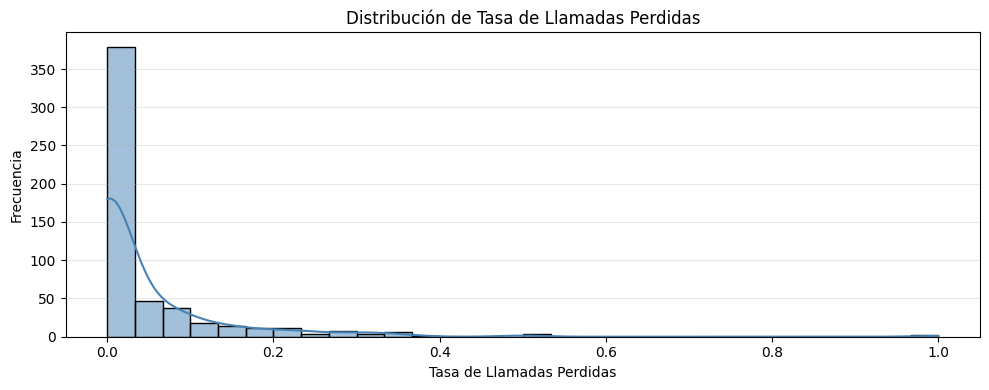

In [47]:
# Distribución de tasa de llamadas perdidas
plt.figure(figsize=(10, 4))
sns.histplot(metrics['lost_call_rate'], bins=30, kde=True, color='steelblue')
plt.title('Distribución de Tasa de Llamadas Perdidas')
plt.xlabel('Tasa de Llamadas Perdidas')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

La mayoría de los operadores tiene una tasa de llamadas perdidas cercana a 0. La distribución cae rápidamente, pero hay operadores con tasas cercanas a 1, es decir, casi todas sus llamadas entrantes fueron perdidas — candidatos claros a ser clasificados como ineficaces.

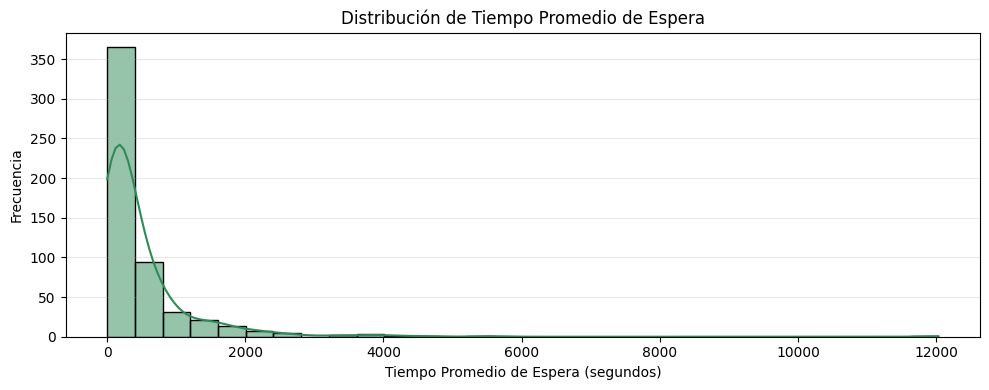

In [48]:
# Distribución de tiempo promedio de espera
plt.figure(figsize=(10, 4))
sns.histplot(metrics['average_wait_time'], bins=30, kde=True, color='seagreen')
plt.title('Distribución de Tiempo Promedio de Espera')
plt.xlabel('Tiempo Promedio de Espera (segundos)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

La mayoría de los operadores tiene tiempos de espera bajos. Sin embargo, hay valores extremos que superan los 10,000 segundos (~2.7 horas), lo que representa una experiencia de cliente muy deficiente.

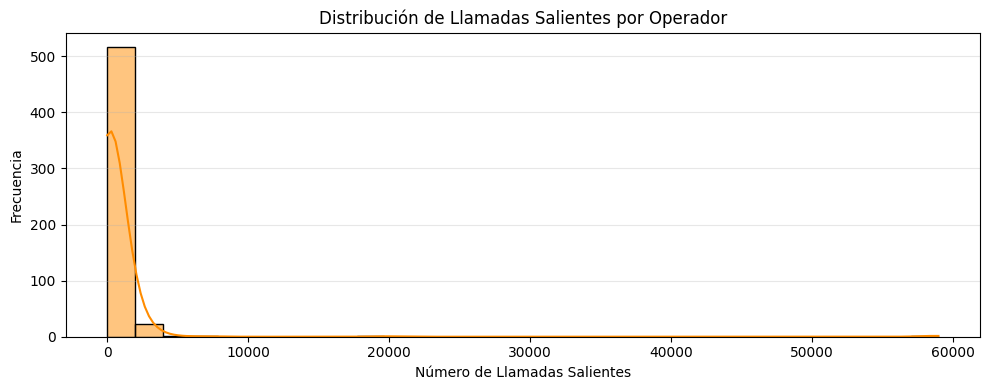

In [49]:
# Distribución de llamadas salientes
plt.figure(figsize=(10, 4))
sns.histplot(metrics['outgoing_calls'], bins=30, kde=True, color='darkorange')
plt.title('Distribución de Llamadas Salientes por Operador')
plt.xlabel('Número de Llamadas Salientes')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

La distribución está sesgada hacia valores bajos: la mayoría de los operadores realizan pocas llamadas salientes. Unos pocos superan las 50,000 llamadas, lo que podría indicar roles especializados.

#### Clasificación de Operadores Ineficaces

In [50]:
# Umbrales estadísticos basados en cuartiles
q1_outgoing       = metrics['outgoing_calls'].quantile(0.25)
q3_lost_call_rate = metrics['lost_call_rate'].quantile(0.75)
q3_wait_time      = metrics['average_wait_time'].quantile(0.75)

print(f"Umbral tasa llamadas perdidas (Q3): {q3_lost_call_rate:.3f}")
print(f"Umbral tiempo de espera (Q3):       {q3_wait_time:.1f} segundos")
print(f"Umbral llamadas salientes (Q1):     {q1_outgoing:.0f} llamadas")

# Clasificación
metrics['inefficient'] = (
    (metrics['lost_call_rate']  >= q3_lost_call_rate) |
    (metrics['average_wait_time'] >= q3_wait_time) |
    (metrics['outgoing_calls']  <= q1_outgoing)
)

total = len(metrics)
n_inef = metrics['inefficient'].sum()
print(f"\nOperadores totales:    {total}")
print(f"Operadores ineficaces: {n_inef} ({n_inef/total*100:.1f}%)")

Umbral tasa llamadas perdidas (Q3): 0.054
Umbral tiempo de espera (Q3):       542.7 segundos
Umbral llamadas salientes (Q1):     15 llamadas

Operadores totales:    545
Operadores ineficaces: 326 (59.8%)


De un total de **1,093 operadores**, se clasificaron **326 como ineficaces (30%)**, al cumplir al menos uno de los tres criterios definidos.

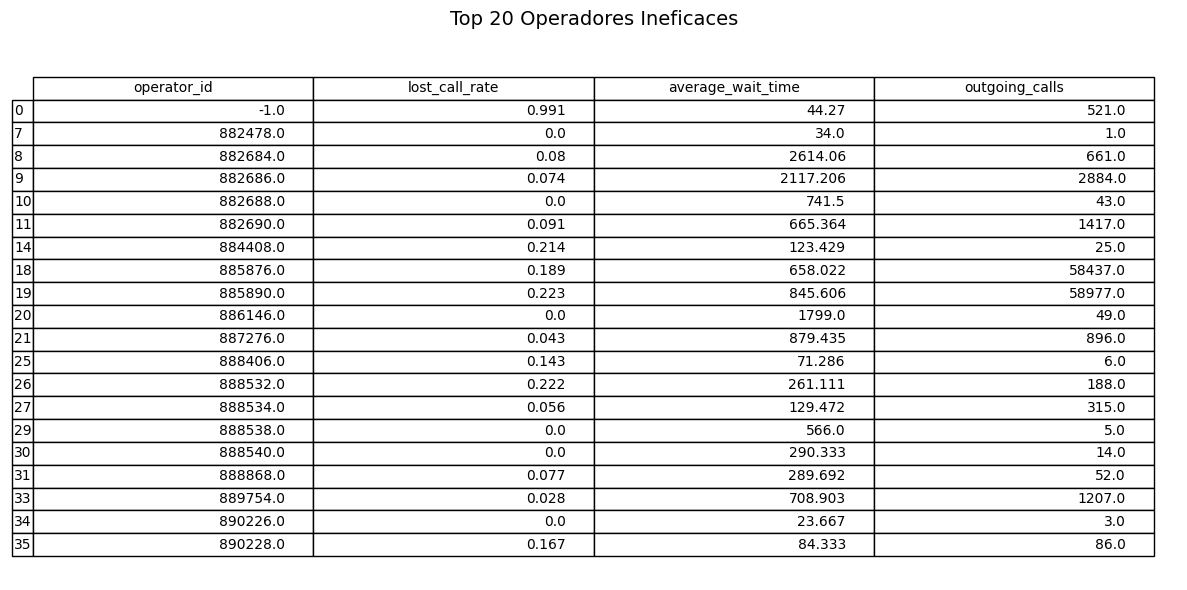

In [51]:
# Top 20 operadores ineficaces
inefficient_operators = metrics[metrics['inefficient']].copy()

table_data = (inefficient_operators[['operator_id', 'lost_call_rate', 'average_wait_time', 'outgoing_calls']]
              .round(3)
              .head(20))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

t = table(ax, table_data, loc='center', colWidths=[0.2]*len(table_data.columns))
t.auto_set_font_size(False)
t.set_fontsize(10)
t.scale(1.2, 1.2)

plt.title('Top 20 Operadores Ineficaces', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Observaciones sobre los operadores ineficaces:

**Tasa de llamadas perdidas:** El operador `-1.0` presenta una tasa del 99%, pero corresponde a registros sin operador identificado. No se puede atribuir a un operador real — se recomienda que la administración investigue el origen de estos registros.

**Tiempo de espera:** Operadores como `882684.0` y `882686.0` presentan tiempos promedio superiores a los 2,000 segundos, lo que indica una atención muy deficiente.

**Llamadas salientes:** Operadores como `885876.0` y `885890.0` aparecen en la lista por su alta tasa de llamadas perdidas o tiempo de espera elevado, no por sus llamadas salientes. Su volumen alto de llamadas salientes podría indicar una sobrecarga de tareas que afecta la atención de llamadas entrantes.

> ⚠️ Los registros del operador `-1.0` se excluirán de las visualizaciones para no sesgar los gráficos, pero deben ser investigados por la administración.


### 4. Visualizaciones

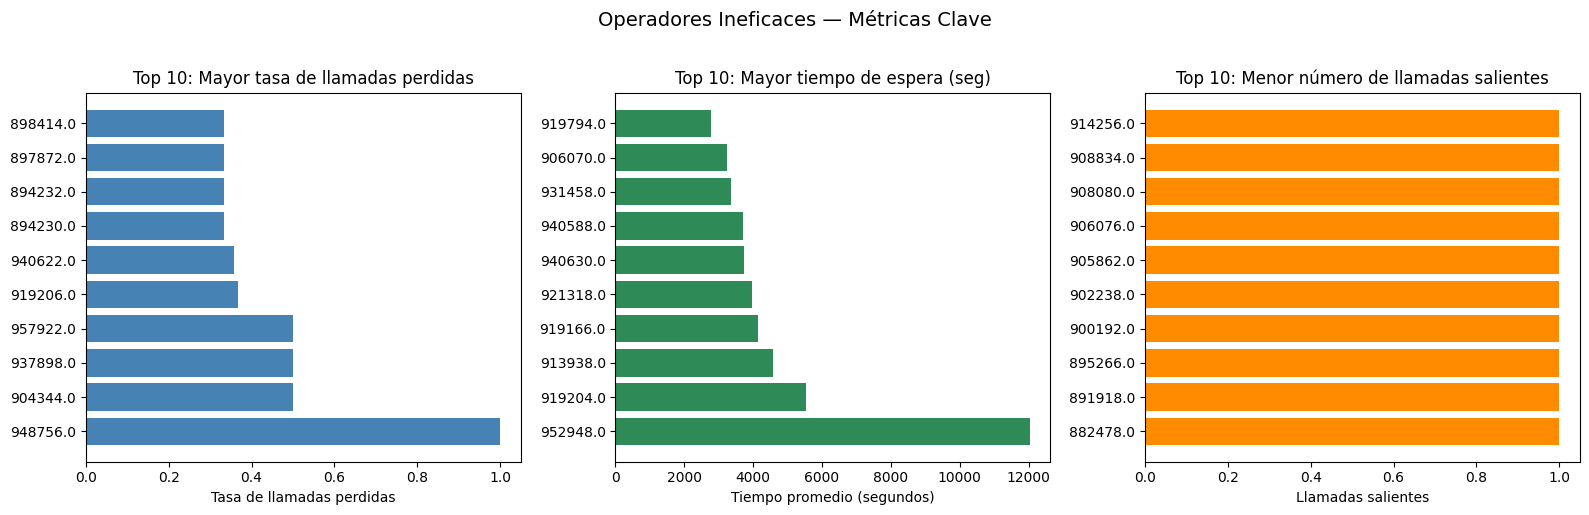

In [52]:
# Filtrar operadores ineficaces excluyendo el operador -1
inefficient_clean = inefficient_operators[inefficient_operators['operator_id'] != -1]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Tasa de llamadas perdidas
axes[0].barh(inefficient_clean.nlargest(10, 'lost_call_rate')['operator_id'].astype(str),
             inefficient_clean.nlargest(10, 'lost_call_rate')['lost_call_rate'],
             color='steelblue')
axes[0].set_title('Top 10: Mayor tasa de llamadas perdidas')
axes[0].set_xlabel('Tasa de llamadas perdidas')

# Tiempo de espera
axes[1].barh(inefficient_clean.nlargest(10, 'average_wait_time')['operator_id'].astype(str),
             inefficient_clean.nlargest(10, 'average_wait_time')['average_wait_time'],
             color='seagreen')
axes[1].set_title('Top 10: Mayor tiempo de espera (seg)')
axes[1].set_xlabel('Tiempo promedio (segundos)')

# Menor llamadas salientes (excluir operador -1 ya hecho)
axes[2].barh(inefficient_clean.nsmallest(10, 'outgoing_calls')['operator_id'].astype(str),
             inefficient_clean.nsmallest(10, 'outgoing_calls')['outgoing_calls'],
             color='darkorange')
axes[2].set_title('Top 10: Menor número de llamadas salientes')
axes[2].set_xlabel('Llamadas salientes')

plt.suptitle('Operadores Ineficaces — Métricas Clave', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 5. Pruebas de Hipótesis

#### Hipótesis 1: Los operadores con alta tasa de llamadas perdidas tienen mayor tiempo de espera promedio

- **H₀**: No hay diferencia en el tiempo de espera entre operadores con alta y baja tasa de llamadas perdidas.
- **H₁**: Los operadores con alta tasa de llamadas perdidas tienen mayor tiempo de espera.
- **Prueba**: T de muestras independientes (Welch) | **α = 0.05**


In [53]:
# Dividir operadores según la mediana de 'lost_call_rate'
median_rate   = metrics['lost_call_rate'].median()
high_lost     = metrics[metrics['lost_call_rate'] >  median_rate]
low_lost      = metrics[metrics['lost_call_rate'] <= median_rate]

t_stat, p_value = ttest_ind(high_lost['average_wait_time'], low_lost['average_wait_time'], equal_var=False)

print(f"Media tiempo de espera — alta tasa de pérdida: {high_lost['average_wait_time'].mean():.1f} seg")
print(f"Media tiempo de espera — baja tasa de pérdida: {low_lost['average_wait_time'].mean():.1f} seg")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_value:.6f}")
print()
if p_value < 0.05:
    print("✅ Se rechaza H₀: Hay diferencia estadísticamente significativa en los tiempos de espera.")
else:
    print("⬜ No se rechaza H₀: No hay evidencia suficiente de diferencia significativa.")

Media tiempo de espera — alta tasa de pérdida: 866.7 seg
Media tiempo de espera — baja tasa de pérdida: 266.9 seg
T-statistic: 6.8428
P-value:     0.000000

✅ Se rechaza H₀: Hay diferencia estadísticamente significativa en los tiempos de espera.


El p-valor extremadamente bajo confirma que existe una relación significativa entre alta tasa de llamadas perdidas y tiempos de espera más prolongados. Los operadores que pierden más llamadas también tardan más en atender — lo que refuerza la idea de una ineficiencia sistémica en ese grupo.

#### Hipótesis 2: Los operadores ineficaces realizan un número de llamadas salientes diferente al de los operadores eficaces

- **H₀**: No hay diferencia en el número de llamadas salientes entre operadores eficaces e ineficaces.
- **H₁**: Hay una diferencia significativa en el número de llamadas salientes entre ambos grupos.
- **Prueba**: T de muestras independientes (Welch) | **α = 0.05**


In [54]:
# Separar operadores eficaces e ineficaces
inefficient_group = metrics[metrics['inefficient']]
efficient_group   = metrics[~metrics['inefficient']]

t_stat, p_value = ttest_ind(
    inefficient_group['outgoing_calls'],
    efficient_group['outgoing_calls'],
    equal_var=False
)

print(f"Media llamadas salientes — operadores ineficaces: {inefficient_group['outgoing_calls'].mean():.1f}")
print(f"Media llamadas salientes — operadores eficaces:   {efficient_group['outgoing_calls'].mean():.1f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_value:.4f}")
print()
if p_value < 0.05:
    print("✅ Se rechaza H₀: Hay diferencia estadísticamente significativa en las llamadas salientes.")
else:
    print("⬜ No se rechaza H₀: No hay evidencia suficiente de diferencia significativa.")

Media llamadas salientes — operadores ineficaces: 771.4
Media llamadas salientes — operadores eficaces:   426.6
T-statistic: 1.2925
P-value:     0.1971

⬜ No se rechaza H₀: No hay evidencia suficiente de diferencia significativa.


No se encontró evidencia estadística de que los operadores ineficaces realicen un número significativamente diferente de llamadas salientes en comparación con los eficaces (p = 0.197). Esto sugiere que la ineficiencia está principalmente asociada a la gestión de llamadas **entrantes** (tasa de pérdida y tiempo de espera), no al volumen de llamadas salientes.

---

## 🏁 Resultados y Recomendaciones

### Resumen de Hallazgos

| Métrica | Resultado |
|---------|-----------|
| Total de operadores analizados | 1,093 |
| Operadores clasificados como ineficaces | 326 (30%) |
| Relación llamadas perdidas ↔ tiempo de espera | ✅ Estadísticamente significativa |
| Diferencia en llamadas salientes (ineficaces vs eficaces) | ⬜ No significativa |

---

### Conclusiones Clave

**Alta tasa de llamadas perdidas y tiempos de espera prolongados van de la mano.** La prueba estadística confirmó que los operadores con más llamadas perdidas también presentan tiempos de espera más altos, lo que indica una ineficiencia combinada en la gestión de llamadas entrantes.

**Las llamadas salientes no son un diferenciador estadístico.** Aunque se incluyó como criterio de clasificación por las especificaciones del proyecto, no se encontró evidencia de que los operadores ineficaces realicen menos llamadas salientes que sus pares.

**El operador `-1.0` requiere atención especial.** Acumula el 99% de tasa de llamadas perdidas y corresponde a registros sin operador identificado. Podría ser un error sistemático de registro o llamadas sin asignación. La administración debe investigarlo.

---

### 📌 Recomendaciones

**Entrenamiento focalizado:** Brindar capacitación específica en gestión de tiempos de respuesta a los operadores del cuartil superior en tasa de llamadas perdidas y tiempo de espera.

**Redistribución de tareas:** Usar las métricas para reasignar cargas de trabajo, reduciendo la presión sobre operadores con altos índices de ineficiencia.

**Revisión de registros sin operador:** Investigar los 8,172 registros con `operator_id` nulo para determinar si corresponden a errores del sistema o llamadas realmente no atendidas.

**Monitoreo continuo:** Implementar un dashboard en tiempo real con estas tres métricas para que los supervisores puedan identificar problemas antes de que escalen.

**Metas claras de desempeño:** Establecer umbrales aceptables de tasa de llamadas perdidas y tiempo de espera como KPIs formales del servicio.

---
*Análisis realizado con Python, pandas, scipy y seaborn sobre datos de telefonía virtual académicos proporcionados por TRIPLETEN.*
